# Classification 

The most common supervised learning tasks are regression (predicting values) and classification (predicting classes)

## Setup

In [1]:

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# MNIST

"In this chapter, we will be using the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. This set has been studied so much that it is often called the “Hello World” of Machine Learning: whenever people come up with a new classification algorithm, they are curious to see how it will perform on MNIST. Whenever someone learns Machine Learning, sooner or later they tackle MNIST."

Warning: since Scikit-Learn 0.24, fetch_openml() returns a Pandas DataFrame by default. To avoid this and keep the same code as in the book, we use as_frame=False.

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Datasets loaded by Scikit-Learn generally have a similar dictionary structure including:  
- A DESCR key describing the dataset
- A data key containing an array with one row per instance and one column per
feature
- A target key containing an array with the labels

In [3]:

X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
28 * 28

784

In [5]:
y.shape


(70000,)

There are 70,000 images, and each image has 784 features. This is because each image
is 28×28 pixels, and each feature simply represents one pixel’s intensity, from 0
(white) to 255 (black). Let’s take a peek at one digit from the dataset. All you need to
do is grab an instance’s feature vector, reshape it to a 28×28 array, and display it using
Matplotlib’s imshow() function:

Saving figure some_digit_plot


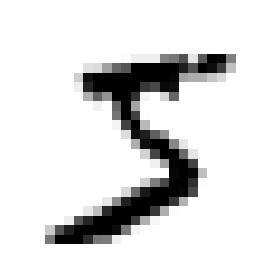

In [6]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [7]:
y[0]


'5'

In [8]:
y = y.astype(np.uint8)


In [9]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [10]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure more_digits_plot


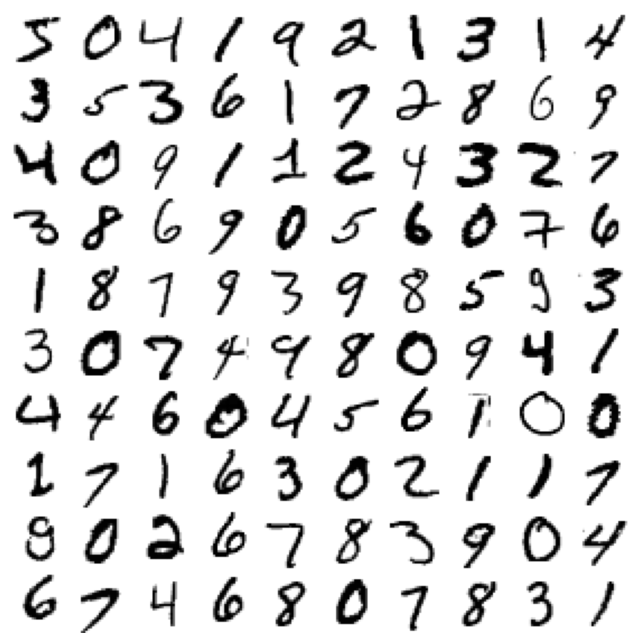

In [11]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

Creating a test set! The MNIST data set is already split up. The first 60,000 items are the training set. The last 10,000 items are the test set

In [12]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]


"Let’s also shuffle the training set; this will guarantee that all cross-validation folds will be similar (you don’t want one fold to be missing some digits). Moreover, some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row. Shuffling the dataset ensures that this won’t happen"

In [13]:
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Binary classifier

The 5 classifier. Can determine if a picture is 5 or is not 5

In [14]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Stochastic Gradient Descent is a good classifier to start with! It can handle very large datasets efficiently. This is because SGD deals with training instances independently, one at a time (which also makes SGD well suited for online learning)  

Note: The SGDClassifier relies on randomness during training (hence
the name “stochastic”). If you want reproducible results, you
should set the random_state parameter

In [15]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train[:1000], y_train_5[:1000])

SGDClassifier(random_state=42)

Now it can detect images for 5! some_digit is 5 so it guessed correctly

In [16]:
sgd_clf.predict([some_digit])


array([ True])

## Performance Measures

"Evaluating a classifier is often significantly trickier than evaluating a regressor, so we will spend a large part of this chapter on this topic."

## Measuring Accuracy Using Cross-Validation

"The StratifiedKFold class performs stratified sampling (as explained in Chapter 2) to produce folds that contain a representative ratio of each class. At each iteration the code creates a clone of the classifier, trains that clone on the training folds, and makes predictions on the test fold. Then it counts the number of correct predictions and outputs the ratio of correct predictions."

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.96285
0.96195
0.9563


"Let’s use the cross_val_score() function to evaluate your SGDClassifier model using K-fold cross-validation, with three folds. Remember that K-fold crossvalidation means splitting the training set into K-folds (in this case, three), then making predictions and evaluating them on each fold using a model trained on the remaining folds (see Chapter 2):"

In [18]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9681 , 0.95655, 0.95515])

Above 95% accuracy!!!!

Wait..." let’s look at a very dumb classifier that just classifies every single image in the “not-5” class:"

In [19]:

from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [20]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.90745, 0.9125 ])

"That’s right, it has over 90% accuracy! This is simply because only about 10% of the
images are 5s, so if you always guess that an image is not a 5, you will be right about
90% of the time. Beats Nostradamus.  

This demonstrates why accuracy is generally not the preferred performance measure
for classifiers, especially when you are dealing with skewed datasets (i.e., when some
classes are much more frequent than others)."

# Confusion Matrix

"A much better way to evaluate the performance of a classifier is to look at the confusion matrix. The general idea is to count the number of times instances of class A are classified as class B. For example, to know the number of times the classifier confused images of 5s with 3s, you would look in the 5th row and 3rd column of the confusion matrix."  

"To compute the confusion matrix, you first need to have a set of predictions, so they can be compared to the actual targets. You could make predictions on the test set, but let’s keep it untouched for now (remember that you want to use the test set only at the very end of your project, once you have a classifier that you are ready to launch). Instead, you can use the cross_val_predict() function:"

In [21]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

"Just like the cross_val_score() function, cross_val_predict() performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold. This means that you get a clean prediction for each instance in the training set (“clean” meaning that the prediction is made by a model that never saw the data during training"  

"Now you are ready to get the confusion matrix using the confusion_matrix() function.
Just pass it the target classes (y_train_5) and the predicted classes
(y_train_pred):"

In [22]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53124,  1455],
       [  949,  4472]], dtype=int64)

Row = actual class  

Column = Predicted class

Row 1 = non-5 images  
53124 correctly classified as non-5, 1455 incorrectly identified (false positive)
  
Row 2 = 5 images  
949 wrongly classified as non-5 (false negatives), 4472 correctly classified as 5s (true positives)



"A perfect classifier would have only true positives and true
negatives, so its confusion matrix would have nonzero values only on its main diagonal
(top left to bottom right):"

In [23]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

"The confusion matrix gives you a lot of information, but sometimes you may prefer a
more concise metric. An interesting one to look at is the accuracy of the positive predictions;
this is called the precision of the classifier (Equation 3-1)."

"TP is the number of true positives, and FP is the number of false positives.
A trivial way to have perfect precision is to make one single positive prediction and
ensure it is correct (precision = 1/1 = 100%). This would not be very useful since the
classifier would ignore all but one positive instance. So precision is typically used
along with another metric named recall, also called sensitivity or true positive rate
(TPR): this is the ratio of positive instances that are correctly detected by the classifier
(Equation 3-2)."   

"An interesting one to look at is the accuracy of the positive predictions;
this is called the precision of the classifier"

"So precision is typically used
along with another metric named recall, also called sensitivity or true positive rate
(TPR): this is the ratio of positive instances that are correctly detected by the classifier"

Pg 85

Scikit learn provides a method to calculate the precision score

In [24]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.754513244474439

In [25]:
cm = confusion_matrix(y_train_5, y_train_pred)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.754513244474439

Scikit learn provides a method to calculate the recall score

In [26]:
recall_score(y_train_5, y_train_pred)


0.8249400479616307

In [27]:
cm[1, 1] / (cm[1, 0] + cm[1, 1])


0.8249400479616307

"Now your 5-detector does not look as shiny as it did when you looked at its accuracy.
When it claims an image represents a 5, it is correct only 75% of the time. Moreover,
it only detects 82% of the 5s."

Scikit learn provides a method to determine the harmonic mean of precision and recall

In [28]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7881565033486078

In [29]:
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)


0.7881565033486077

## Precision/Recall Tradeoff

"The F1 score favors classifiers that have similar precision and recall. This is not always what you want: in some contexts you mostly care about precision, and in other contexts you really care about recall. For example, if you trained a classifier to detect videos
that are safe for kids, you would probably prefer a classifier that rejects many
good videos (low recall) but keeps only safe ones (high precision), rather than a classifier
that has a much higher recall but lets a few really bad videos show up in your
product (in such cases, you may even want to add a human pipeline to check the classifier’s
video selection). On the other hand, suppose you train a classifier to detect
shoplifters on surveillance images: it is probably fine if your classifier has only 30%
precision as long as it has 99% recall (sure, the security guards will get a few false
alerts, but almost all shoplifters will get caught).
Unfortunately, you can’t have it both ways: increasing precision reduces recall, and
vice versa. This is called the precision/recall tradeoff."   


pg 87

In [30]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([962625.43408593])

In [31]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [32]:
y_some_digit_pred


array([ True])

In [33]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [34]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [35]:

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Saving figure precision_recall_vs_threshold_plot


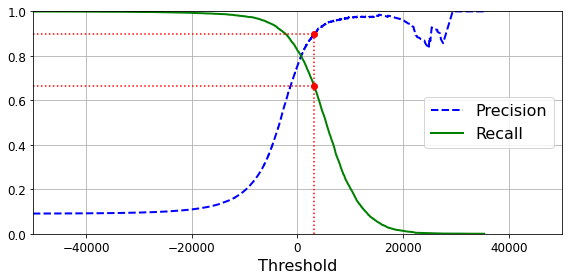

In [36]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

In [37]:
(y_train_pred == (y_scores > 0)).all()


True

Saving figure precision_vs_recall_plot


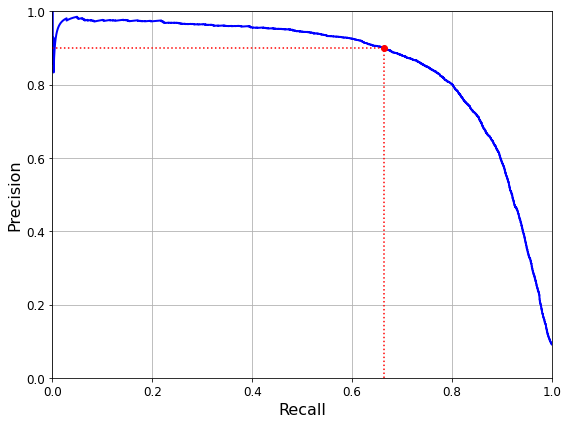

In [38]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

In [39]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


In [40]:
threshold_90_precision


3214.58435004113

In [41]:
y_train_pred_90 = (y_scores >= threshold_90_precision)


In [42]:
precision_score(y_train_5, y_train_pred_90)


0.9

In [43]:
recall_score(y_train_5, y_train_pred_90)


0.6640841173215274

"Great, you have a 90% precision classifier (or close enough)! As you can see, it is
fairly easy to create a classifier with virtually any precision you want: just set a high
enough threshold, and you’re done. Hmm, not so fast. A high-precision classifier is
not very useful if its recall is too low!"

## The Roc Curve 

"The receiver operating characteristic (ROC) curve is another common tool used with
binary classifiers. It is very similar to the precision/recall curve, but instead of plotting
precision versus recall, the ROC curve plots the true positive rate (another name
for recall) against the false positive rate. The FPR is the ratio of negative instances that
are incorrectly classified as positive. It is equal to one minus the true negative rate,
which is the ratio of negative instances that are correctly classified as negative. The
TNR is also called specificity. Hence the ROC curve plots sensitivity (recall) versus
1 – specificity."

In [44]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Saving figure roc_curve_plot


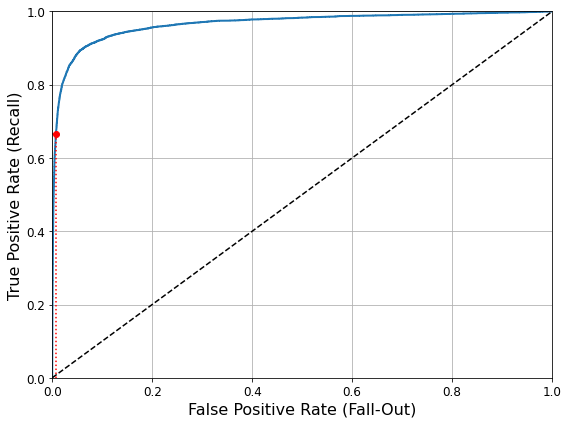

In [45]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')                           # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
save_fig("roc_curve_plot")                                    # Not shown
plt.show()

"Once again there is a tradeoff: the higher the recall (TPR), the more false positives
(FPR) the classifier produces. The dotted line represents the ROC curve of a purely
random classifier; a good classifier stays as far away from that line as possible (toward
the top-left corner)."   

"One way to compare classifiers is to measure the area under the curve (AUC). A perfect
classifier will have a ROC AUC equal to 1, whereas a purely random classifier will
have a ROC AUC equal to 0.5. Scikit-Learn provides a function to compute the ROC
AUC:"

In [46]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9660259463088996

Important!!!   

"Since the ROC curve is so similar to the precision/recall (or PR)
curve, you may wonder how to decide which one to use. As a rule
of thumb, you should prefer the PR curve whenever the positive
class is rare or when you care more about the false positives than
the false negatives, and the ROC curve otherwise. For example,
looking at the previous ROC curve (and the ROC AUC score), you
may think that the classifier is really good. But this is mostly
because there are few positives (5s) compared to the negatives
(non-5s). In contrast, the PR curve makes it clear that the classifier
has room for improvement (the curve could be closer to the topright
corner)."

"Let’s train a RandomForestClassifier and compare its ROC curve and ROC AUC
score to the SGDClassifier. First, you need to get scores for each instance in the
training set. But due to the way it works (see Chapter 7), the RandomForestClassi
fier class does not have a decision_function() method. Instead it has a pre
dict_proba() method. Scikit-Learn classifiers generally have one or the other. The
predict_proba() method returns an array containing a row per instance and a column
per class, each containing the probability that the given instance belongs to the
given class (e.g., 70% chance that the image represents a 5):"

In [47]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

"But to plot a ROC curve, you need scores, not probabilities. A simple solution is to
use the positive class’s probability as the score"

In [48]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

Saving figure roc_curve_comparison_plot


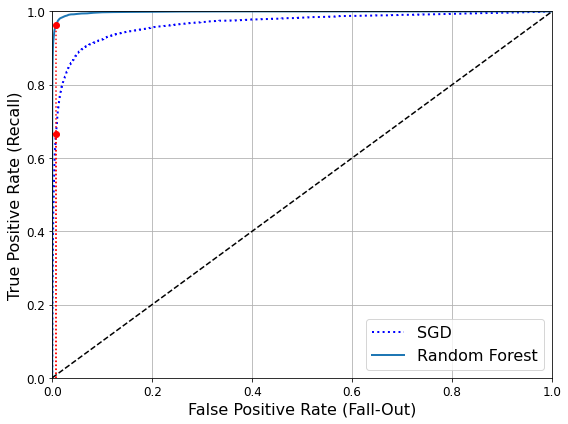

In [49]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

"As you can see in Figure 3-7, the RandomForestClassifier’s ROC curve looks much
better than the SGDClassifier’s: it comes much closer to the top-left corner. As a
result, its ROC AUC score is also significantly better:"

In [50]:
roc_auc_score(y_train_5, y_scores_forest)


0.9983631764491033

Good precision and recall too!!!

In [51]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9890893831305078

In [52]:
recall_score(y_train_5, y_train_pred_forest)


0.8695812580704667

# Multiclass Classification

"Whereas binary classifiers distinguish between two classes, multiclass classifiers (also called multinomial classifiers) can distinguish between more than two classes."

"Some algorithms (such as Random Forest classifiers or naive Bayes classifiers) are capable of handling multiple classes directly. Others (such as Support Vector Machine classifiers or Linear classifiers) are strictly binary classifiers. However, there are various strategies that you can use to perform multiclass classification using multiple binary classifiers."

"For example, one way to create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, and so on). Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score. This is called the one-versus-all (OvA) strategy (also called one-versus-the-rest)."

"Another strategy is to train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. This is called the one-versus-one (OvO) strategy. If there are N classes, you need to train N × (N – 1) / 2 classifiers. For the MNIST problem, this means training 45 binary classifiers! When you want to classify an image, you have to run the image through all 45 classifiers and see which class wins the most duels. The main advantage of OvO is that each classifier only needs to be trained on the part of the training set for the two classes that it must distinguish."

"Some algorithms (such as Support Vector Machine classifiers) scale poorly with the
size of the training set, so for these algorithms OvO is preferred since it is faster to
train many classifiers on small training sets than training few classifiers on large
training sets. For most binary classification algorithms, however, OvA is preferred."

"Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass
classification task, and it automatically runs OvA (except for SVM classifiers for
which it uses OvO). Let’s try this with the SGDClassifier:"

In [53]:
sgd_clf.fit(X_train[:1000], y_train[:1000])
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

"That was easy! This code trains the SGDClassifier on the training set using the original target classes from 0 to 9 (y_train), instead of the 5-versus-all target classes (y_train_5). Then it makes a prediction (a correct one in this case). Under the hood, Scikit-Learn actually trained 10 binary classifiers, got their decision scores for the image, and selected the class with the highest score."

In [54]:
sgd_clf.decision_function([some_digit])


array([[-4520273.66562347, -2937086.27059985, -1913528.52175626,
        -1124142.74974597, -5994685.34020283,   761331.15577161,
        -4680522.04049906, -4642467.465826  , -4265506.40301952,
        -4019405.94184126]])

Now let's try with a Support Vector Machine

In [55]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train, not y_train_5
svm_clf.predict([some_digit])

array([8], dtype=uint8)

In [56]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 8.16593933,  7.15880384,  3.98277096, -0.2062723 ,  2.89912035,
         1.87138996,  0.83996083,  6.12150827,  9.17832647,  5.01230928]])

In [57]:
np.argmax(some_digit_scores)


8

In [58]:
svm_clf.classes_


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [59]:
svm_clf.classes_[5]


5

You can force Scikit Learn to use OVA (OneVsRestClassifier) or OVO (OneVsOneClassifier)

In [60]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([8], dtype=uint8)

In [61]:
# from sklearn.multiclass import OneVsOneClassifier
# ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
# ovo_clf.fit(X_train, y_train)
# ovo_clf.predict([some_digit])

In [62]:
# len(ovo_clf.estimators_)


It is also easy to train a random forests. This time Scikit-Learn did not have to run OvA or OvO because Random Forest
classifiers can directly classify instances into multiple classes. You can call
predict_proba() to get the list of probabilities that the classifier assigned to each
instance for each class

In [63]:
# forest_clf.fit(X_train, y_train)
# forest_clf.predict([some_digit])
# forest_clf.predict_proba([some_digit])

In [64]:
len(ovr_clf.estimators_)


10

Remember to cross validate!

In [71]:
# cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

"It gets over 84% on all test folds. If you used a random classifier, you would get 10%
accuracy, so this is not such a bad score, but you can still do much better. For example,
simply scaling the inputs (as discussed in Chapter 2) increases accuracy above
90%:"

In [72]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
# cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

## Error Analyis 

"Of course, if this were a real project, you would follow the steps in your Machine
Learning project checklist (see Appendix B): exploring data preparation options, trying
out multiple models, shortlisting the best ones and fine-tuning their hyperparameters
using GridSearchCV, and automating as much as possible, as you did in the
previous chapter. Here, we will assume that you have found a promising model and
you want to find ways to improve it. One way to do this is to analyze the types of
errors it makes."

In [75]:
# y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5568,    1,   35,    9,   12,   60,   59,    2,  167,   10],
       [   1, 6137,   43,   46,   10,   74,   25,   29,  359,   18],
       [  34,   45, 4836,  106,   72,   72,  126,  115,  524,   28],
       [  29,   11,  195, 4749,   27,  470,   30,   94,  465,   61],
       [  23,   11,   31,   10, 5169,   38,   48,   45,  194,  273],
       [  39,   14,   33,   82,   66, 4560,   98,   17,  441,   71],
       [  38,    5,   66,    6,   39,  149, 5516,    6,   90,    3],
       [  26,    7,   44,   34,   71,   30,    6, 5688,  113,  246],
       [  20,   36,   38,   81,   44,  258,   44,   26, 5230,   74],
       [  18,    6,   26,   47,  183,   87,    1,  284,  362, 4935]],
      dtype=int64)

In [76]:
# since sklearn 0.22, you can use sklearn.metrics.plot_confusion_matrix()
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

"That’s a lot of numbers. It’s often more convenient to look at an image representation
of the confusion matrix, using Matplotlib’s matshow() function"

Saving figure confusion_matrix_plot


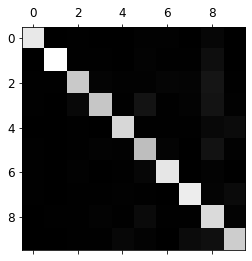

In [77]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

"This confusion matrix looks fairly good, since most images are on the main diagonal,
which means that they were classified correctly. The 5s look slightly darker than the
other digits, which could mean that there are fewer images of 5s in the dataset or that
the classifier does not perform as well on 5s as on other digits. In fact, you can verify
that both are the case."

"Let’s focus the plot on the errors. First, you need to divide each value in the confusion
matrix by the number of images in the corresponding class, so you can compare error
rates instead of absolute number of errors (which would make abundant classes look
unfairly bad):"

In [78]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

"Now let’s fill the diagonal with zeros to keep only the errors, and let’s plot the result:"

Saving figure confusion_matrix_errors_plot


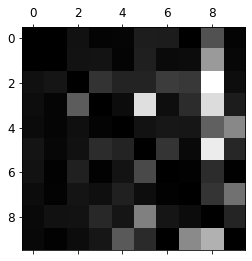

In [79]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

"Now you can clearly see the kinds of errors the classifier makes. Remember that rows
represent actual classes, while columns represent predicted classes. The columns for
classes 8 and 9 are quite bright, which tells you that many images get misclassified as
8s or 9s. Similarly, the rows for classes 8 and 9 are also quite bright, telling you that 8s
and 9s are often confused with other digits. Conversely, some rows are pretty dark,
such as row 1: this means that most 1s are classified correctly (a few are confused
with 8s, but that’s about it). Notice that the errors are not perfectly symmetrical; for
example, there are more 5s misclassified as 8s than the reverse."

"Analyzing the confusion matrix can often give you insights on ways to improve your
classifier. Looking at this plot, it seems that your efforts should be spent on improving
classification of 8s and 9s, as well as fixing the specific 3/5 confusion. For example,
you could try to gather more training data for these digits. Or you could engineer
new features that would help the classifier—for example, writing an algorithm to
count the number of closed loops (e.g., 8 has two, 6 has one, 5 has none). Or you
could preprocess the images (e.g., using Scikit-Image, Pillow, or OpenCV) to make
some patterns stand out more, such as closed loops."

"Analyzing individual errors can also be a good way to gain insights on what your
classifier is doing and why it is failing, but it is more difficult and time-consuming.
For example, let’s plot examples of 3s and 5s:"

Saving figure error_analysis_digits_plot


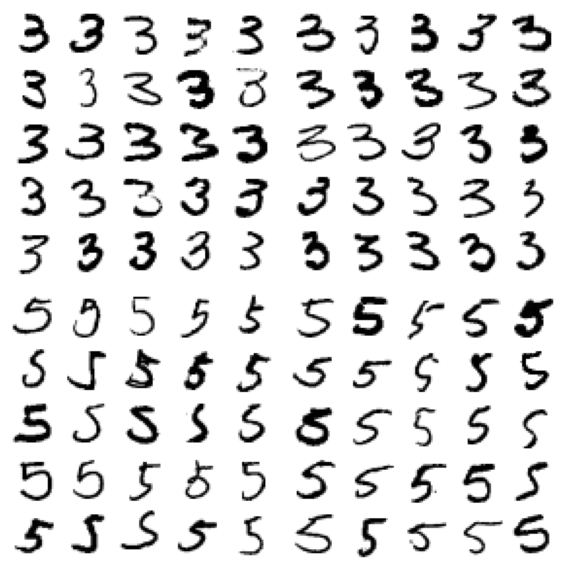

In [80]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

"The two 5×5 blocks on the left show digits classified as 3s, and the two 5×5 blocks on
the right show images classified as 5s. Some of the digits that the classifier gets wrong
(i.e., in the bottom-left and top-right blocks) are so badly written that even a human
would have trouble classifying them (e.g., the 5 on the 8th row and 1st column truly
looks like a 3)."

"However, most misclassified images seem like obvious errors to us,
and it’s hard to understand why the classifier made the mistakes it did.3 The reason is
that we used a simple SGDClassifier, which is a linear model. All it does is assign a
weight per class to each pixel, and when it sees a new image it just sums up the weighted
pixel intensities to get a score for each class. So since 3s and 5s differ only by a few
pixels, this model will easily confuse them."

"The main difference between 3s and 5s is the position of the small line that joins the
top line to the bottom arc. If you draw a 3 with the junction slightly shifted to the left,
the classifier might classify it as a 5, and vice versa. In other words, this classifier is
quite sensitive to image shifting and rotation. So one way to reduce the 3/5 confusion
would be to preprocess the images to ensure that they are well centered and not too
rotated. This will probably help reduce other errors as well."